# Preprocesamiento para Experimentos de Actividad Espontánea
 
Este Cuaderno es muy similar al Preprocesamiento para Evocados, pero sin promediar sobre múltiples estímulos. 
Dado que estos experimentos son muy grandes y causan problemas con el RAM, lo que vamos a hacer es primero cortarlos en cachos 
manejables (aproximadamente unos 400MB a lo más), y hacer el preprocesamiento sobre cada subarchivo.
En lugar de eso se recomienda una inspección visual para obtener un intervalo interesante del Archivo Experimental.

In [10]:
include("SeparaActividadySaturados01.jl")
using SeparaActividadySaturados01
using JLD, PyPlot

La mayoría de los experimentos de actividad espontánea producen archivos de varios GB. Es imposible hacer el prerprocesamiento con 
memoría limitada. Es muy probable que haya que dividir el archivo en cachos.

In [11]:
abrestring="/home/karel/BRWFiles/estriado/estriado_slice1_1004AP.brw"
stringgeneral=replace(abrestring, ".brw", "")  

"/home/karel/BRWFiles/estriado/estriado_slice1_1004AP"

In [19]:
tamax=400*1024*1024  #maximo tamaño tolerable de archivo
tam=filesize(abrestring)
cachos=div(tam,tamax)+1

11

In [37]:
Datos=AbreyCheca(abrestring)

Dict{String,Any} with 8 entries:
  "minvolt"     => -4125.0
  "maxvolt"     => 4125.0
  "frecuencia"  => 17855.5
  "DatosCrudos" => UInt16[0x0000, 0x07f6, 0x080c, 0x07fe, 0x07f6, 0x07f6, 0x07f…
  "bitdepth"    => 0x0c
  "factor"      => 2.01416
  "numcuadros"  => 535665
  "duracion"    => 30.0

In [38]:
### parametetros globales.
freq=Datos["frecuencia"]/1000 #cuadros por milisegundo.
factor=Datos["factor"] #Factor de conversion de numeros enteros a microVolts
retrazo=round(Int, ceil(5*freq))
final=round(Int, ceil(60*freq))
latencia=round(Int, ceil(1.5*freq))


27

In [39]:
cuadrosmax=Datos["numcuadros"]
tiempototalms=round(cuadrosmax/freq, 1) 
println("Tienes ", cuadrosmax, " cuadros de muestreo a ", round(freq,4), " cuadros por milisegundo")
println( "Esto corresponde a  ", tiempototalms, "ms." )

Tienes 535665 cuadros de muestreo a 17.8555 cuadros por milisegundo
Esto corresponde a  30000.0ms.


In [40]:
fmemlibre=Sys.free_memory()/Sys.total_memory()

0.19396275231100396

In [41]:
# Si los datos andan en un arreglo de lista en lugar de cuadrado, los ponemos cuadrados
if size(Datos["DatosCrudos"])[1] != 4096
DatosCrudosArreglados=reshape(Datos["DatosCrudos"], (4096, Datos["numcuadros"]))
else
DatosCrudosArreglados=Datos["DatosCrudos"]
end;

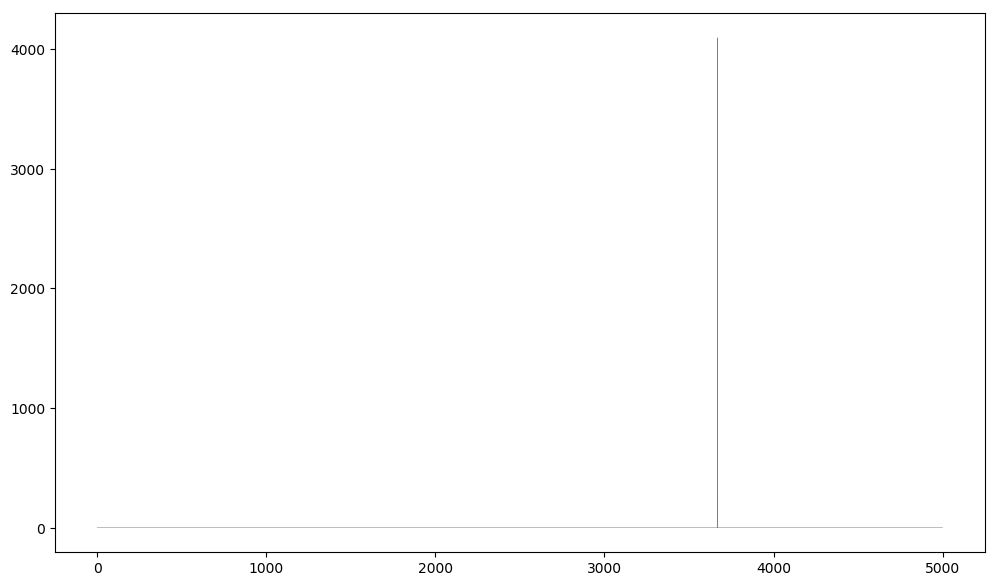

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7f9e31b1c0f0>

In [43]:
figure(figsize=(12,7))

plot(DatosCrudosArreglados[1,1:5000], lw=0.3)

In [44]:
DatosCrudosArreglados[1,1]==0

true

In [46]:
# si la fraccion de memoria libre es inferior a 0.2, tenemos que cortar un cacho de los datos. Que tan chico el cacho depende... 
# toca probar
if cachos > 1
    ## escoga el usuario un cacho para trabajar entre 1 y cachos
    cacho=1
    pedazo=round(Int, Datos["numcuadros"]/cachos)
    if cacho < cachos # si no es el ultimo cacho
     DatosCrudosArreglados=DatosCrudosArreglados[:,(1+(cacho-1)*pedazo):cacho*pedazo]
    else
     DatosCrudosArreglados=DatosCrudosArreglados[:,(1+(cacho-1))*pedazo:cuadrosmax]
    end
    palabritaespecial="/Cacho_$(cacho)_"
else
    palabritaespecial="/Completo_"
end

#    end;
# Liberar memoria
Datos["DatosCrudos"]=0
println( "Este será el identificador del archivo en cachos: ", palabritaespecial)


Este será el identificador del archivo en cachos: /Cacho_1_


In [47]:
size(DatosCrudosArreglados)

(4096, 48697)

In [48]:
 DatosCentrados=FormaMatrizDatosCentrados(DatosCrudosArreglados, factor);
# libera memoria
DatosCrudosArreglados=0

0

In [50]:
ncuadros=size(DatosCentrados)[3]

48697

In [15]:
#los parametros son datos promediados, frecuencia, tiempo post estimulo en ms, umbral en microvolts, umbral de saturación en microvolts
PruebaRespuesta=BuscaCanalRespActPot(DatosCentrados,freq, 120,-120,-800)
# y luego los saturados
iniciobusqueda=2000
finbusqueda=retrazo+10000
Saturados=BuscaSaturados(DatosCentrados,900,iniciobusqueda,finbusqueda)
numerosaturados=length(Saturados)
println("Encontramos ", numerosaturados, " canales probablemente saturados.")
println("Encontramos ", length(PruebaRespuesta), " canales probablemente con actividad.")


Encontramos 26 canales probablemente saturados.
Encontramos 108 canales probablemente con actividad.


In [16]:
finbusqueda

10090

### inspección visual. 
Podemos tomar una imagen de la desviación estándar por canal y sobreponerle unas marcas para los canales "respuesta".
De ahí podemos tomar un ejemplo para dibujar el trazo en ese canal.

In [17]:
DesviacionPorCanal=zeros(64,64)
for j=1:64
    for k=1:64
        ChorizoExemplo=reshape(DatosCentrados[j,k,:],cuadrosmax)
        DesviacionPorCanal[j,k]=std(ChorizoExemplo)
    end
end

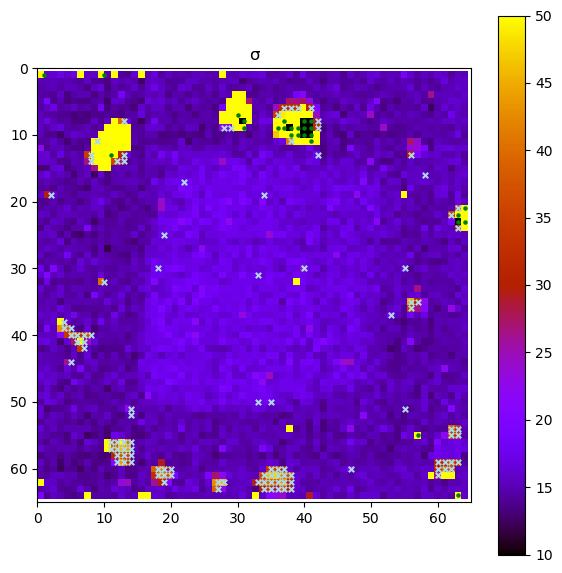

PyObject <matplotlib.collections.PathCollection object at 0x7f81495a8f60>

In [18]:
figure(figsize=(7,7))
xlim(0,65)
ylim(65,0)
title("σ")
limites=50
imagen=imshow(DesviacionPorCanal, origin="lower", interpolation="nearest",cmap="gnuplot", 
                      vmin=10,vmax=limites, extent=[0,64.5,0.5,64.5])
cb=colorbar()

x=[]
y=[]
for j in PruebaRespuesta
  append!(x,j[2])
   append!(y,j[1])
end


x2=[]
y2=[]
for j in Saturados
  append!(x2,j[2])
   append!(y2,j[1])
end


scatter(x,y, marker="x",c="lightblue", s=15)
scatter(x2,y2, marker="o",c="green", s=5)

In [19]:
Saturados

Set(Array{Int64,1}[[64, 63], [22, 63], [9, 38], [21, 64], [9, 41], [9, 37], [8, 37], [10, 41], [9, 31], [11, 41]  …  [55, 57], [8, 40], [10, 40], [8, 41], [13, 11], [23, 63], [9, 39], [10, 38], [10, 39], [8, 31]])

Escogamos uno de los que parecen estar en la "sombra luminosa" del Cuerno de Amon y que estén marcados con x blanca.

In [20]:
egtrazo=DatosCentrados[13,11,:];

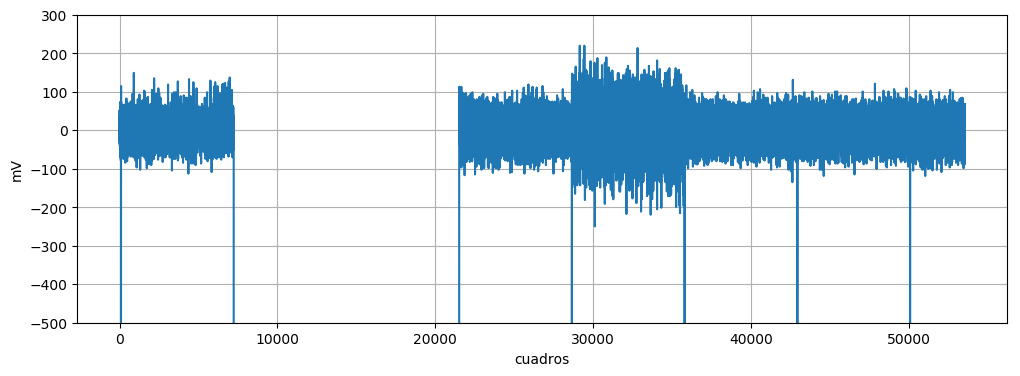

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7f8149291eb8>

In [27]:
figure(figsize=(12,4))
xlabel("cuadros")
ylabel("mV")
ylim(-500,300)
#subintervalo a graficar, por omision, todo primero, es decir desde=1, hasta=cuadrosmax
desde=29000
hasta=34000
intervalo=1:cacho
#intervalo=desde:hasta
grid()
plot(intervalo,egtrazo[intervalo])

Tomaremos el intervalo interesante y guardaremos esos datos en un archivo con toda la información de saturados y respuestas, 
de la misma forma que como se hace con los evocados. A diferencia de éstos, no tenemos parámetros de latencia, en lugar de eso
tendremos una indicacion de "de donde a donde se cortaron los datos", en cuadros.

In [23]:
dirname(stringgeneral), basename(stringgeneral)

("/home/karel/BRWFiles/estriado", "estriado_slice1_1004AP")

In [24]:
dirgen=dirname(stringgeneral)
basegen=basename(stringgeneral)
#una palabra para indicar el intervalo 
outname=string(dirgen,palabritaespecial, basegen, ".jld")
#aqui hay que arreglar el rollo del directorio

save(outname,
     "LFPSaturados", DatosCentrados[:,:,desde:hasta],
     "desde", desde,
    "hasta", hasta,
     "freq",freq,
     "Canalesrespuesta", PruebaRespuesta,
     "CanalesSaturados", Saturados)
println("hemos guardado este cacho en el archivo ", outname)